# Traffic Light Detection and Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

## Object detection imports

Here are the imports from the object detection module.

In [2]:
import label_map_util
import visualization_utils as vis_util

## Model preparation

In [3]:
faster_rcnn_sim_model = '../models/frozen_real/frozen_inference_graph.pb'

PATH_TO_LABELS = 'label_map.pbtxt'

NUM_CLASSES = 4

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': u'Green'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'off'}}


In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [6]:
from glob import glob

## Detection

## 1. Testing Faster R-CNN Inception Models

### 1.1 Testing model trained on real images

In [7]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(faster_rcnn_sim_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [8]:
PATH_TO_TEST_IMAGES_DIR = './test_images/real'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
# print("Length of test images:", len(TEST_IMAGE_PATHS))
print(len(TEST_IMAGE_PATHS))
print(TEST_IMAGE_PATHS)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

./test_images/real/*.jpg
15
['./test_images/real/left0487.jpg', './test_images/real/left0009.jpg', './test_images/real/left0486.jpg', './test_images/real/left0089.jpg', './test_images/real/left0182.jpg', './test_images/real/left0241.jpg', './test_images/real/left0008.jpg', './test_images/real/left0088.jpg', './test_images/real/left0240.jpg', './test_images/real/left0010.jpg', './test_images/real/left0242.jpg', './test_images/real/left0183.jpg', './test_images/real/left0090.jpg', './test_images/real/left0181.jpg', './test_images/real/left0485.jpg']


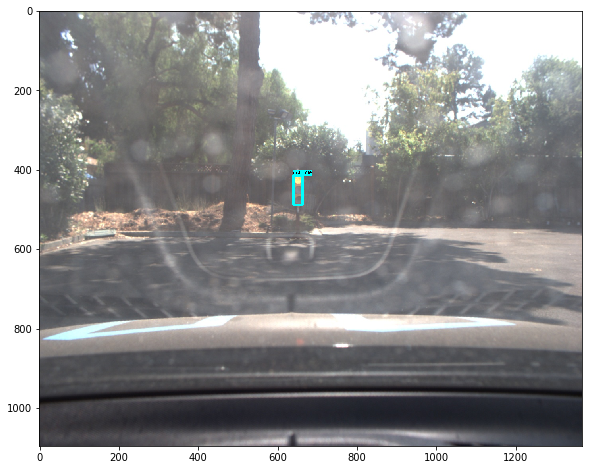

=== Info Summary ===
./test_images/real/left0487.jpg
('Red', 0.99958736)
detection time: 7.78928112984


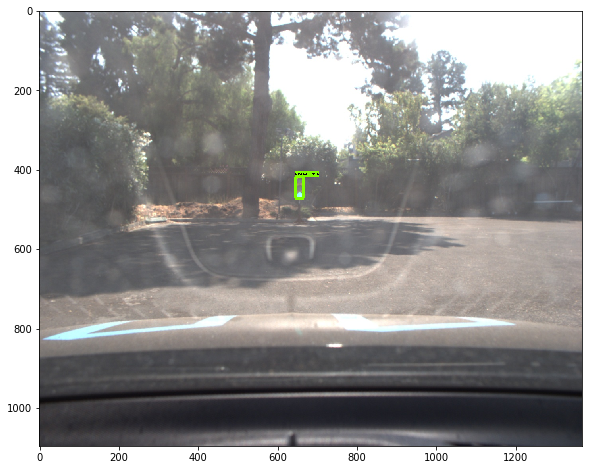

=== Info Summary ===
./test_images/real/left0009.jpg
('Green', 0.9901163)
detection time: 6.72618699074


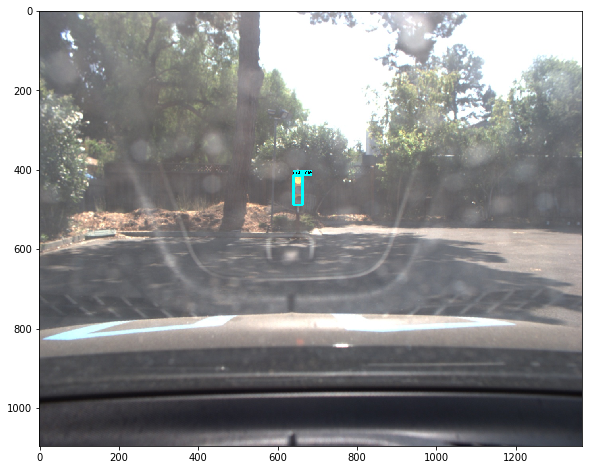

=== Info Summary ===
./test_images/real/left0486.jpg
('Red', 0.99960452)
detection time: 6.70295214653


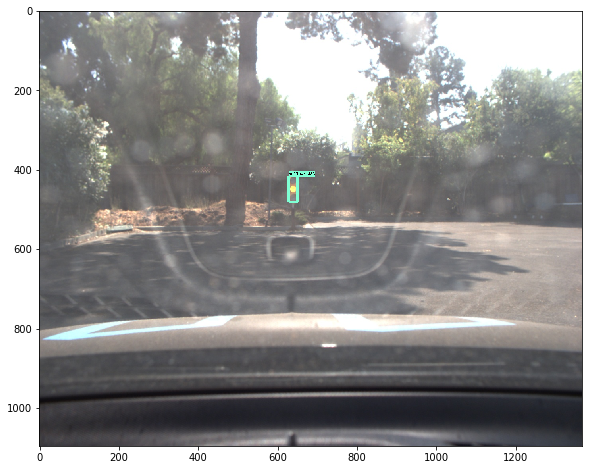

=== Info Summary ===
./test_images/real/left0089.jpg
('Yellow', 0.9902845)
detection time: 6.78494310379


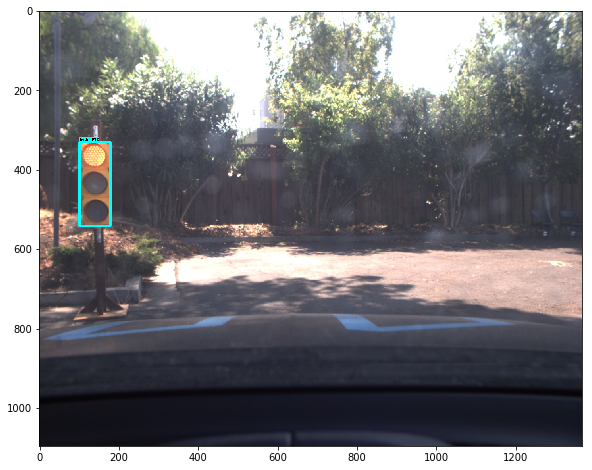

=== Info Summary ===
./test_images/real/left0182.jpg
('Red', 0.99877888)
detection time: 6.67729711533


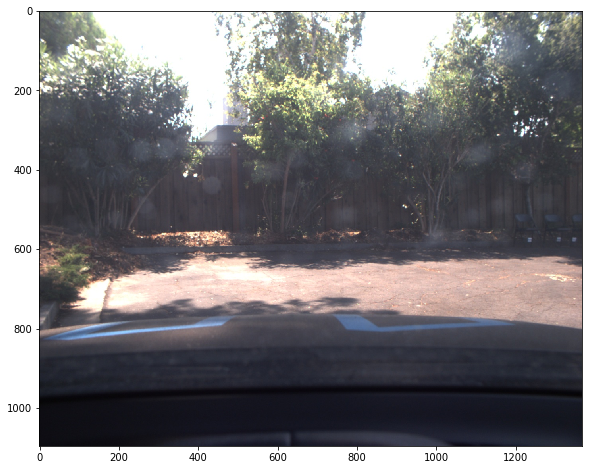

=== Info Summary ===
./test_images/real/left0241.jpg
detection time: 6.70155191422


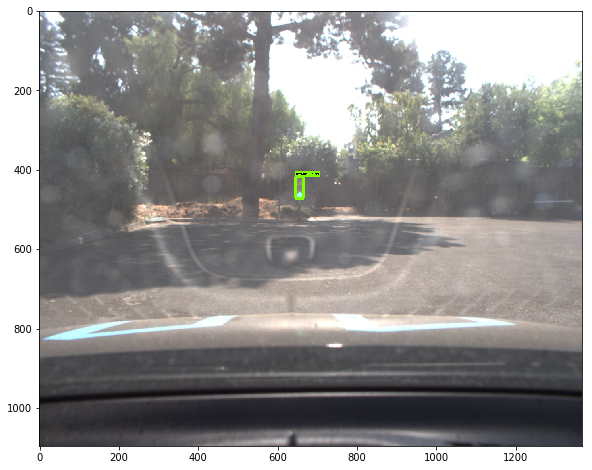

=== Info Summary ===
./test_images/real/left0008.jpg
('Green', 0.9912923)
detection time: 6.71282505989


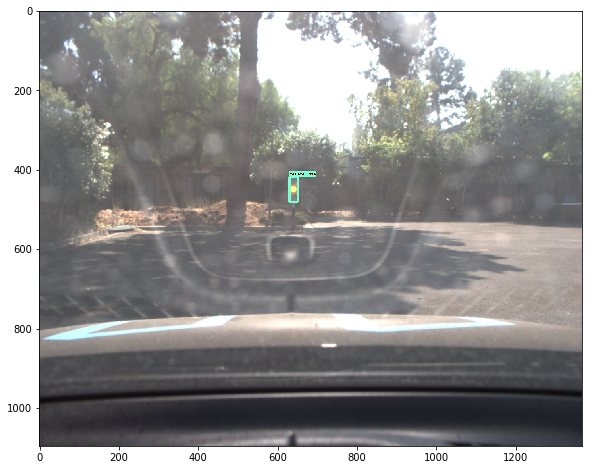

=== Info Summary ===
./test_images/real/left0088.jpg
('Yellow', 0.99353057)
detection time: 6.71207809448


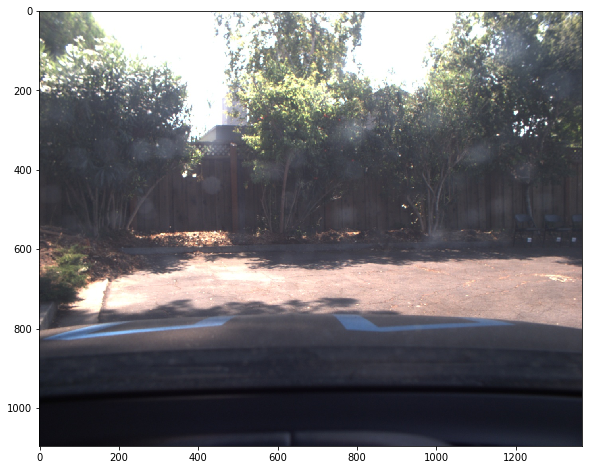

=== Info Summary ===
./test_images/real/left0240.jpg
detection time: 6.68496489525


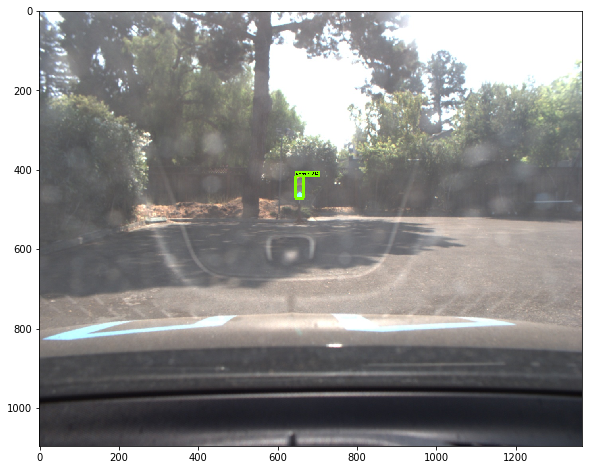

=== Info Summary ===
./test_images/real/left0010.jpg
('Green', 0.98975664)
detection time: 6.74519991875


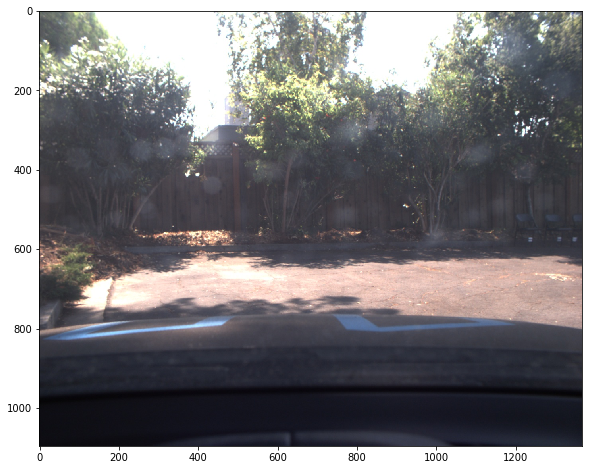

=== Info Summary ===
./test_images/real/left0242.jpg
detection time: 6.69945502281


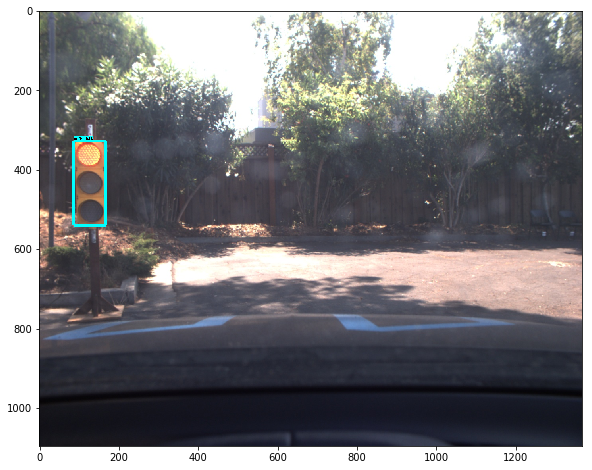

=== Info Summary ===
./test_images/real/left0183.jpg
('Red', 0.9986136)
detection time: 6.74424409866


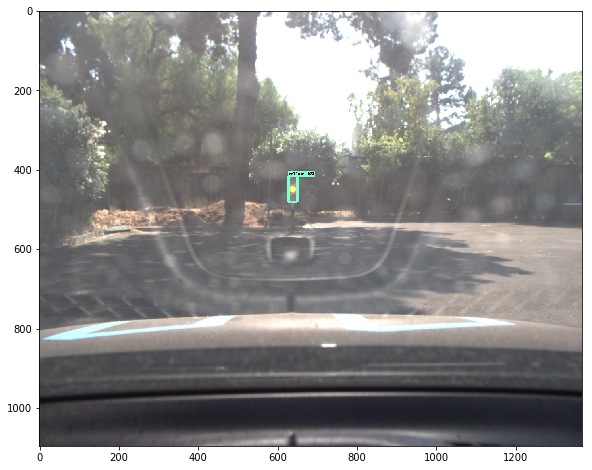

=== Info Summary ===
./test_images/real/left0090.jpg
('Yellow', 0.97472429)
detection time: 6.78086686134


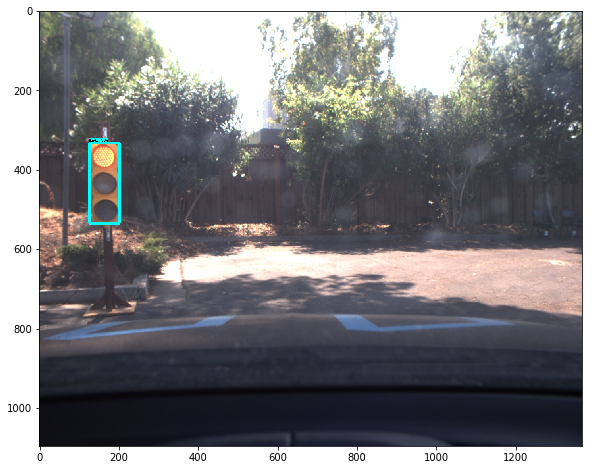

=== Info Summary ===
./test_images/real/left0181.jpg
('Red', 0.99902546)
detection time: 6.78498101234


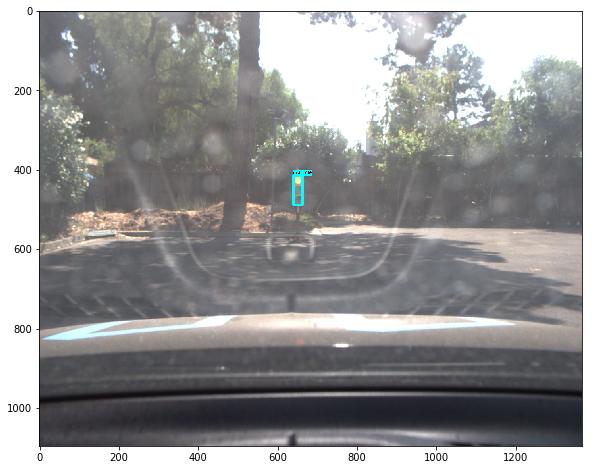

=== Info Summary ===
./test_images/real/left0485.jpg
('Red', 0.99958819)
detection time: 6.77903103828


In [9]:
import time
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            time_on_detection = time.time() - time0
            

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .30
            print("=== Info Summary ===")
            print(image_path)
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
            print("detection time: " + str(time.time() - time0))
